In [112]:
import polars as pl
from pathlib import Path
import json
import seaborn as sns
import seaborn.objects as so
import numpy as np
import matplotlib.pyplot as plt

### Peak Memory Usage

In [40]:
mem_dir = Path('/cellar/users/dlaub/projects/ML4GLand/EUGENe_paper/scripts/training_mem/memray')
n_seq = []
length = []
load = []
peak_mem = []
for path in mem_dir.glob('*.json'):
    n_seq.append(int(path.stem.split('_')[2].split('=')[1]))
    length.append(int(path.stem.split('_')[3].split('=')[1]))
    load.append('load' in path.stem)
    with open(path) as f:
        peak_mem.append(json.load(f)['metadata']['peak_memory'] / 1e6)
mem_df = (
    pl.DataFrame({'n_seq': n_seq, 'length': length, 'peak_mem': peak_mem, 'load': load})
    .with_columns((pl.col('n_seq') * pl.col('length')).alias('size'))
)
mem_df.head()

n_seq,length,peak_mem,load,size
i64,i64,f64,bool,i64
1000000,1000,2209.374945,true,1000000000
100,10000,229.8576,false,1000000
1000,10000,276.716167,false,10000000
100,5000,219.853149,true,500000
100,10000,230.853649,true,1000000


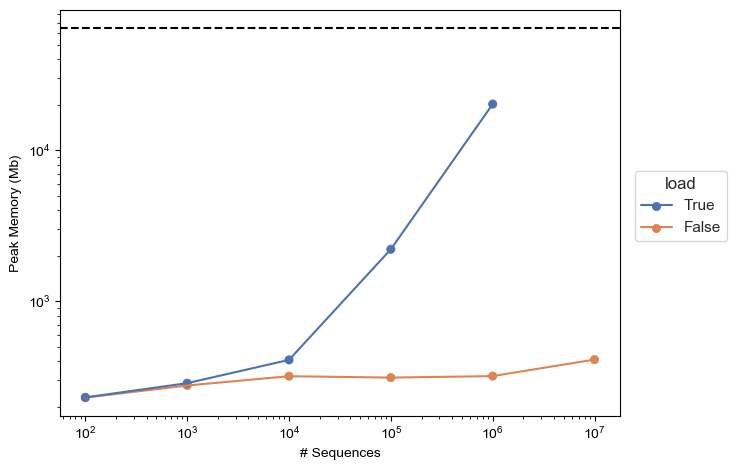

In [117]:
mem_data = mem_df.filter(
    (pl.col('length') == int(1e4))
    & ~(  # drop the OOM run
        (pl.col('load') == True)
        & (pl.col('n_seq') == int(1e7))
    )
)
fig, ax = plt.subplots()
p = (
    so.Plot(mem_data.to_pandas(), x='n_seq', y='peak_mem', color='load')
    .add(so.Line())
    .add(so.Dot())
    .scale(x='log', y='log')
    .label(x='# of 10kb Sequences', y='Peak Memory (MB)', color='Loaded into memory.')
    .theme(sns.axes_style('ticks'))
    .on(ax)
)
p.plot()
ax.axhline(64e3, c='k', ls='--', label='Max Memory (64 GB)')
fig.legend(loc='center left')
_ = fig.tight_layout()

### Speed

In [86]:
data_dir = Path('/cellar/users/dlaub/projects/ML4GLand/EUGENe_paper/scripts/training_mem/data/rechunked')
n_seq = []
length = []
load = []
median_time = []
for path in data_dir.glob('*.npy'):
    n_seq.append(int(path.stem.split('_')[1].split('=')[1]))
    length.append(int(path.stem.split('_')[2].split('=')[1]))
    load.append('load' in path.stem)
    median_time.append(np.load(path))
speed_df = (
    pl.DataFrame({'n_seq': n_seq, 'length': length, 'median_time': median_time, 'load': load})
    .explode('median_time')
)
speed_df.head()

n_seq,length,median_time,load
i64,i64,f64,bool
1000000,10000,0.289311,true
1000000,10000,0.186207,true
1000000,10000,0.185743,true
1000000,10000,0.194099,true
1000000,10000,0.192374,true


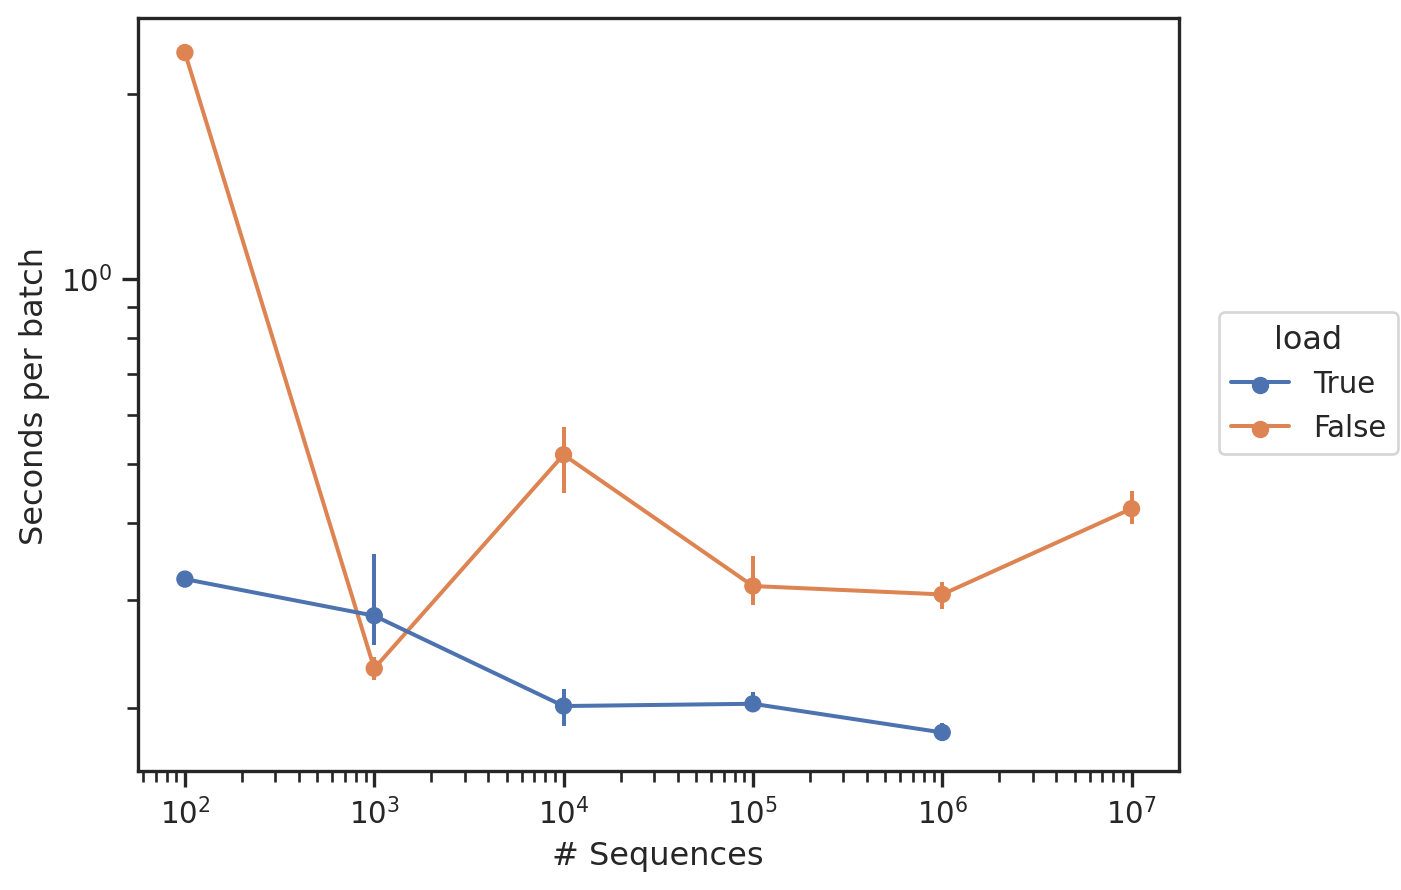

In [116]:
def interval(x):
    return np.quantile(x, 0.25), np.quantile(x, 0.75)
speed_data = speed_df.filter(pl.col('length') == int(1e4))
fig, ax = plt.subplots()
p = (
    so.Plot(speed_data.to_pandas(), x='n_seq', y='median_time', color='load')
    .add(so.Line(), so.Agg('median'))
    .add(so.Dot(), so.Agg('median'))
    .add(so.Range(), so.Est('median', errorbar=interval))
    .scale(x='log', y='log')
    .label(x='# of 10kb Sequences', y='Seconds per batch', color='Loaded into memory.')
    .theme(sns.axes_style('ticks'))
    .on(ax)
)
p.plot()
fig.tight_layout()
